In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# explore database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Look at column names and types
m_columns = inspector.get_columns('measurement')
print('Measurement')
for c in m_columns:
    print(c['name'], c["type"])

print('\nStation')
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [8]:
# We can view all of the classes that automap found
# I used the inspector before I got here, but may as well do this in two ways.
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Explore Measurement
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [45]:
# Explore Station
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

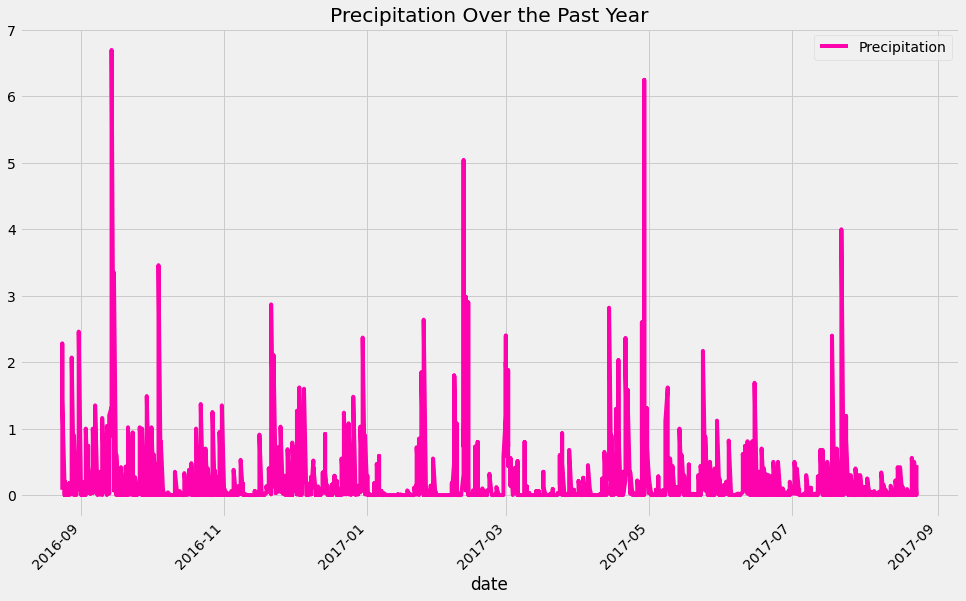

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
mostRecent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(mostRecent) - 08/23/2017
firstDate = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= firstDate).\
    order_by(Measurement.date).all()
#print(data)

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(data, columns=['date', 'prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
# Hopefully my order_by in the query took care of this, but just in case
# Convert index from string to date
df.index = pd.to_datetime(df.index)
p_df = df.sort_index(ascending=True)

# I see a NaN in the prcp column
p_df = p_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
p_df.plot(rot=45, figsize=(15,10), color='#fc03ad')
plt.legend(['Precipitation'], loc=1)
plt.title('Precipitation Over the Past Year')
plt.show()

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
p_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [44]:
# Design a query to show how many stations are available in this dataset?
numStations = session.query(Station.id).count()
numStations

9

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]
activityCounts = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activityCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Get most active station ID
mostActive = activityCounts[0][0]

# Calculate values
session.query(Measurement.station,
              func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == mostActive).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temp Distribution at Station USC00519281')

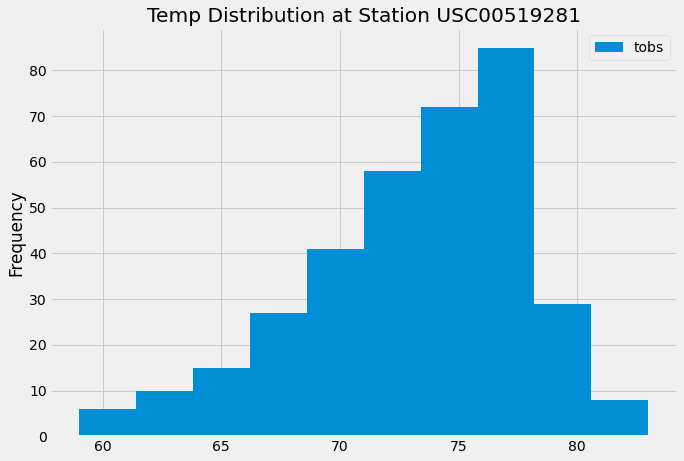

In [65]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# In case there are NaNs in the tobs column, don't just use the station with most activity
sel = [Measurement.station, func.count(Measurement.tobs)]
tobsCounts = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
mostActive = tobsCounts[0][0]

data = session.query(Measurement.date, Measurement.tobs).\
               filter(Measurement.station == mostActive).\
               filter(Measurement.date >= firstDate).all()

tobs_df = pd.DataFrame(data, columns=['date', 'tobs'])
# tobs_df.head()
tobs_df.plot(kind='hist', figsize=(10,7))
plt.legend(['tobs'], loc=0)
plt.title('Temp Distribution at Station USC00519281')

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
